## Business Problem

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company. My target here is to explore the data in a way that business would run and give a suggestion based on the finding. I am not try to achive the best model, but I try to develop model that viable and useful in the long run. In this data exploration and machine learning development, I also want to explore the possibility whether we need machine learning model to provide leads or random sampling are enough. With simulation we would assess that.

I am assumeed the customers in question is an insurance customer with Health insurance from the company and the policy is still In-force. The data provided is in customer (policy holder) level and the agent would offer the new policy to the policy holder (whether it is for the insured or the family). 

The data is retrieved from the Kaggle website: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

In [1]:
import seaborn as sns
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
train = pd.read_csv('train.csv')

<IPython.core.display.Javascript object>

In [2]:
test = pd.read_csv('test.csv')

<IPython.core.display.Javascript object>

In [3]:
#my own function for effect size
import scipy.stats as ss
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [4]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Dataset Exploration and Preprocessing

From the data, there are not many information given to have a sharp analysis because most of the data are basic customer profile and policy profile. However, let's see if the information is already enough to develop adequate machine learning model for the business.

In [6]:
# Drop unnecessary data
train.drop('id', axis =1, inplace = True)

In [7]:
# Change to Categorical data
train['Region_Code'] = train['Region_Code'].astype('string')
train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].astype('string')
train['Driving_License'] = train['Driving_License'].astype('string')
train['Previously_Insured'] = train['Previously_Insured'].astype('string')

In [8]:
#Statistic for numeric data
train.describe()

,Age,Annual_Premium,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397,0.122563
std,15.511611,17213.155057,83.671304,0.327936
min,20.000000,2630.000000,10.000000,0.000000
25%,25.000000,24405.000000,82.000000,0.000000
50%,36.000000,31669.000000,154.000000,0.000000
75%,49.000000,39400.000000,227.000000,0.000000
max,85.000000,540165.000000,299.000000,1.000000


In [9]:
#statistic for categorical data
train.describe(exclude = 'number')

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
count,381109,381109,381109,381109,381109,381109,381109
unique,2,2,53,2,3,2,155
top,Male,1,28.0,0,1-2 Year,Yes,152.0
freq,206089,380297,106415,206481,200316,192413,134784


<IPython.core.display.Javascript object>

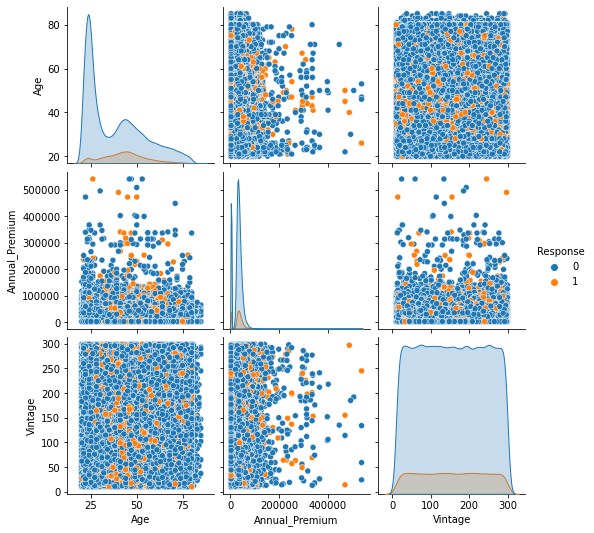

In [10]:
#Numerical data exploration
sns.pairplot(train, hue = 'Response')

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Annual_Premium'>

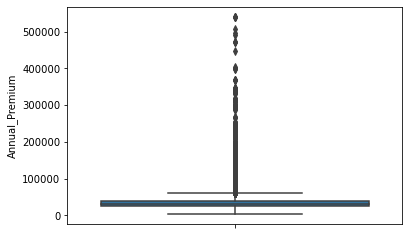

In [11]:
#Boxplot for ANP because the distribution is right skew
sns.boxplot(y = train['Annual_Premium'])

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Age'>

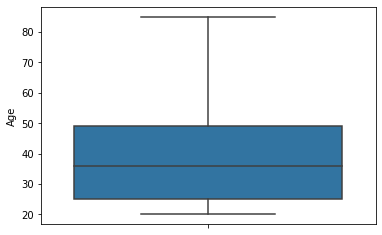

In [12]:
sns.boxplot(y = train['Age'], hue = train['Response'])

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Response', ylabel='Age'>

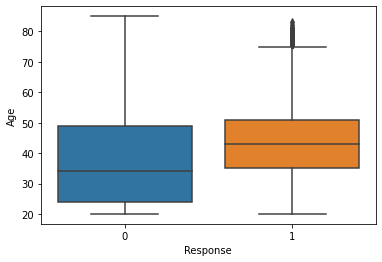

In [13]:
#Older customer have a higher chance for Cross-Selling although only until around 70
sns.boxplot(x= train['Response'], y = train['Age'])

I want to create a new feature based on the Annual Premium because in the insurance Industry is common to segmented the customer based on the ANP. I am not sure regarding India Insurance segmentation, but based on the data and my own knowledge I would try to split into two segment; High ANP and Lower ANP with the division whether the ANP higher than 100000 Indian Rupee or not.

In [14]:
train['High_ANP'] = train['Annual_Premium'].apply(lambda x: '1' if x > 100000 else '0')

<IPython.core.display.Javascript object>

C:\Users\MSI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Response', ylabel='count'>

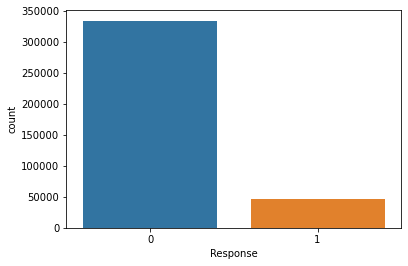

In [15]:
#Target exploration
sns.countplot(train['Response'])

<IPython.core.display.Javascript object>

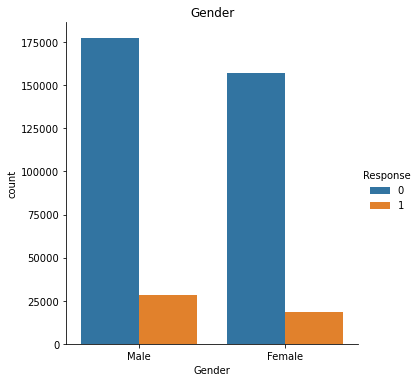

<IPython.core.display.Javascript object>

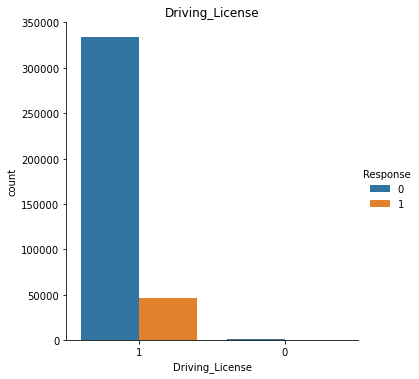

<IPython.core.display.Javascript object>

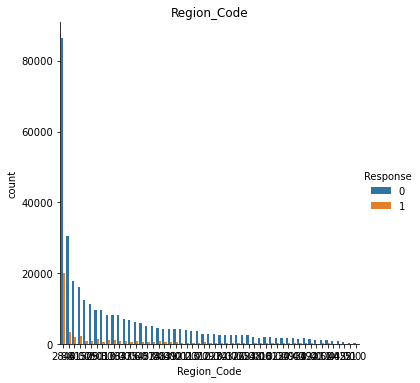

<IPython.core.display.Javascript object>

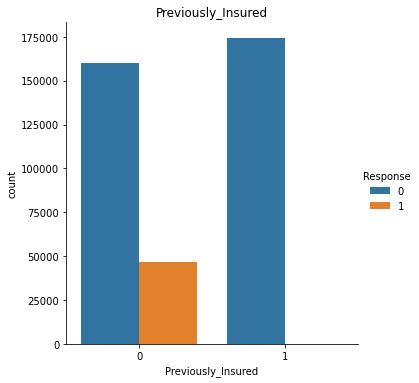

<IPython.core.display.Javascript object>

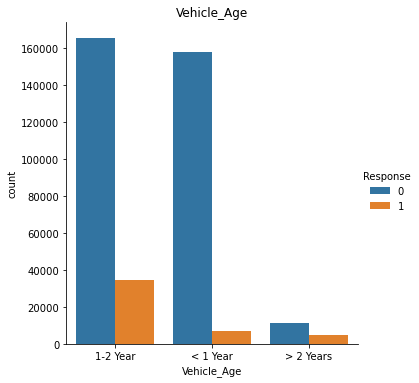

<IPython.core.display.Javascript object>

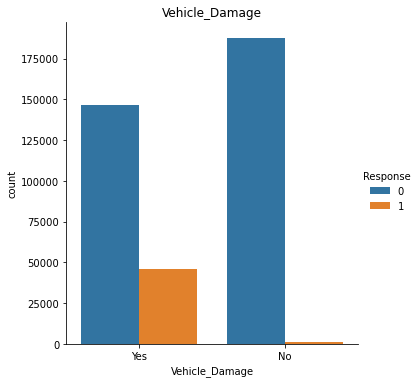

<IPython.core.display.Javascript object>

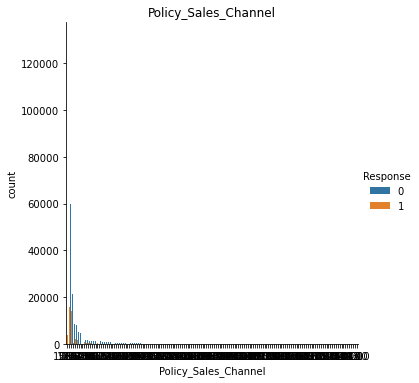

<IPython.core.display.Javascript object>

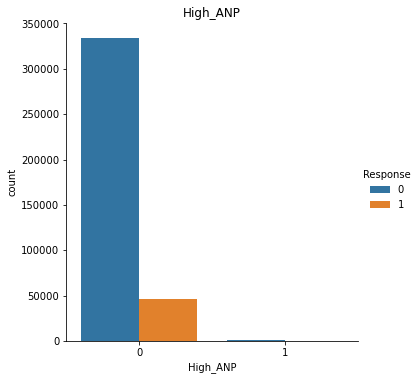

In [16]:
#Categorical data exploration
for i in train.select_dtypes(exclude = 'number').columns:
    sns.catplot(x=i, kind="count", hue = 'Response', data=train, order = train[i].value_counts().index)
    plt.title(i)
    plt.show()

## Effect Size and Hypothesis Testing

To know the prediction strength from the independent feature to the target, I would employ various statistical calculataion and hypothesis testing

In [17]:
#Numerical Column Effect Size with Correlation Ratio
corr_ratio = []
for i in train.select_dtypes(include = 'number').columns:
    corr_ratio.append(correlation_ratio(train['Response'], train[i]))
res = pd.DataFrame(data = [ train.select_dtypes(include = 'number').columns, corr_ratio] 
             ).T 
res.columns = ['Column', 'Correlation Ratio']
res.sort_values(by = 'Correlation Ratio', ascending = False).reset_index(drop = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Column,Correlation Ratio
0,Response,1.0
1,Age,0.111147
2,Annual_Premium,0.022575
3,Vintage,0.00105


In [18]:
#Categorical Column Effect Size with Cramer's V

cramers = []
for i in train.select_dtypes(exclude = 'number').columns:
    cramers.append(cramers_v(train['Response'], train[i]))
res = pd.DataFrame(data = [train.select_dtypes(exclude = 'number').columns, cramers] 
             ).T 
res.columns = ['Column', 'Cramers_V']
res.sort_values(by = 'Cramers_V', ascending = False).reset_index(drop = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Column,Cramers_V
0,Vehicle_Damage,0.354388
1,Previously_Insured,0.341159
2,Policy_Sales_Channel,0.262661
3,Vehicle_Age,0.221925
4,Region_Code,0.1376
5,Gender,0.052407
6,Driving_License,0.009937
7,High_ANP,0.004531


## Insight from Initial Exploration

There are 12 features (11 independent and 1 dependent) available from the dataset, however only 9 feature are viable. Based on experience, I assumes these features are useless:
1. ID - Not useful because it is customer identifier
2. Region Code - High Cardinal (53 dimension) and in my experience, the presence of Region Code would easily drift the data as the business change could easily affecting this data
3. Policy Sales Channel - High Cardinal (155 dimension) and Sales Channel are easily added and removed which not good for the machine learning

Feature above are useful for data analysis and report but not machine learning model development, thus I would removed them.

From the data exploration above, here are some insight I found:
1. The Response feature (Target) are imbalance, only ~12% customers are interested for Cross-Selling. I am not sure the customer interested for cross-selling here, is it successfully converted or only successfully contacted (interest for calling). In this project, I would assume the interested customer would always do Cross-Selling.
2. Driving License are not useful because almost all customer have a driving license and it would be bad for business to insured someone who did not own Driving License. This feature could become a rule-based decision where we would not offer vehicle insurance to someone without Driving License
3. From the data, all the customer vintage were under a year and follow the uniform distribution even when separated by the dependent. Vintage feature could be useful, but mostly if we have data more than a year as comparison. In our case, vintage are not useful to predict the customer interest.
4. Previously Insured and Vehicle Damage is the most useful feature to predict the Response feature, basically all the customer with no vehicle insurance and have damage their vehicle in the past would interested in the Vehicle Insurance from this company.
5. Many of the customer vehicle age are less than 1 year or between 1 to 2 years, however the customers with 1 to 2 years vehicle age might interested to buy the vehicle insurance
6. Older customer might have slightly better chance for cross-selling.

From the analysis, I would only consider using 6 features for Machine Learning development --> 
Vehicle Damage, Previously Insured, Vehicle Age, Gender, and High ANP.

## Business Simulation

Before we continue with the machine learning development, we need to consider the business aspect when we deploy this model. With business simulation we could plan on our target and  The model would produce leads for agent to approach customer with higher probability of cross-selling. Unfortunately, there are no information regarding the number of the agent and the cost for contacting customers. 

Why this information is important? because if there are no cost associated with contacting customer and wrongly prediction, then why not just called them all rather than rely on machine learning model?. Furthermore we need to consider the project timeline and number of agent who could execute the leads because it would affect business target as well. 

Why there is a timeline? Imagine the model predict 50000 customers would do Cross-Selling, will the agent execute all 50000 customers within one day? obviously not (except if there are 50000 agent for each customer) and the agent would definetly have priotization customers they would call. Maybe you would think if we could let the agent call the leads anytime as long as we have predict they would cross-selling; the problem is the customer's life would change over time and the prediction might not valid in that situation (data drift). That is why project timeline affect both the business and our technical aspect.   


Let's try to outline what variable within the business we need to considers:

1. Business Target (From this project, what is the business target to track; often is the sales number or conversion)
2. Cost for approach/call (All cost associated with the call, operational cost, agent tips, etc.)
3. Agent number
4. Timeline
5. Success conversion income (How much success cross-sell contribution to the ANP)
6. Leads number (How many leads would be called during the timeline)
7. Model metrics

There are still many variables we could think of, but let's stick with the simplest one first. What to do then with this variables? we need to build a simulation with this variables based on the business process that happens. The process could be anything because I don't know how the process in this specific company, but I could try simulate it based on my experience. My target is to simulate would we achieve our target or not. 

Let's say Business Target (BT) is our ultimate goal which we need to achieve or surpass during our Timeline (T) in month. In the project, after receiving the prediction, we would give a certain number of leads (L) to be processed within the timeline by the Agent (A). Let's assume that every agent only need to call for conversion so the only thing we need to concern of is the Cost for Call (C). Each call would affected by the number of agent and project timeline where higher agent number and lower timeline would increase the cost and vice versa. Finally, the success conversion Income (S) is the coefficient for each success call. The total income would affected by the model metrics (M) and the leads number (how many success call from the leads number that translaTe to the income). Why model metrics as well? because not all call would 100% success. 

The business process would be only the leads that predicted for interested are the one that were called.

If we make it into linear equation, we would write it as:

$BT <= (S * (L * M)) - (L*(C * (A/T))$

We already establish the variable and equation. Now, we only need to fill it up. The Cost is fixed number by business which we could tweak around but the success conversion income are varied in each success (except if you want to say the product always produce fixed Income/ANP). In this case, we could use the historical data from the customer ANP; for example the average or median. For our case, let's take the Train data Annual Premium Average. 

In [19]:
#Rounding the ANP Average per cases
round(train['Annual_Premium'].mean())

30564

In [45]:
def business_target_simulation(S, L, M, C, A, T):
    revenue = (S*(L * M)) - (L * (C * (T/A)))
    return revenue

Let's define some of the variable, we have:
- Business Target; Let's say this year we want to achieve 10.000.000 Indian Rupee  from Cross-Selling program 
- Timeline would be a year, which means 12 Months
- Cost per call let's say 5000 Indian Rupee
- Agent number let's say 100
- Number of Leads would related to the existing population because it is Cross-Selling program. The test data contain 127037 people. From the train data, we see around 12% population are interested for sales. If we take 12% of the rest data as leads (assumed the prediction model might follow the same probability distribution) then we have 15244 customer as leads.
- For model metric, let's assume we use Precision because we need to calculate the True Positive cases from the predicted interest to buy. Because the business process would only call the leads predicted interested, then we need to maximize the precision of class 1 (interested). Why? because if the False Positive too high (low precision) means there are too many call make without successull income; sans, more cost. Our cost are associated with the Positive cases (Either True or False).
We want to define our technical KPI as well, so let's simulate various Precision number.

In [46]:
def simulation_plot(metric_range, S, L, C, A, T, BT):
    result = []
    for score in metric_range:
        result.append(business_target_simulation(S=S, L=L, M = score, C=C, A=A, T=T))
    plt.figure(figsize = (8,8))
    img = plt.plot(metric_range, result, marker = 'o') 
    plt.axhline(BT, color  = 'red')
    return img                  

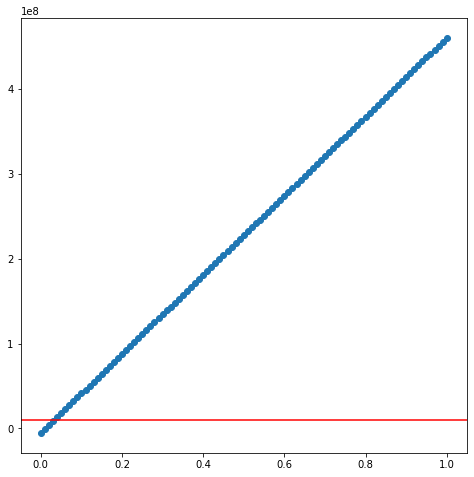

In [47]:
simulation_plot(metric_range = np.arange(0, 1.01, 0.01), S = 30564, L = 15244, C = 3000,  A = 100, T =12, BT = 10000000)

## Simulation Result

From our simulation, if we want to achieve the minimum target of 10.000.000 indian rupee within a year with the variables we set up previously, we would need at least model that achieve 82% in the precision of class 1. Quite high target, but certainly posibble. With this in mind, when we setup our model and MLOps, we need to make sure that the precision always higher than 82%. You could always change the metric to another such as Accuracy, Recall, etc. however we need to tweak the equation as well if we did that.

Of course, this simulation is based on the linear assumption and haven't consider the randomness factor and error. We could try to play around with the confidence interval, but let's keep that for a later discussion. 

# Machine Learning Development

From our simulation, we need to achieve 82% Precision in order to have a model that would meet the business target. We would experimenting with various methods and model available to reach the target. 

Let's start with data preprocessing and preparation.

In [23]:
#Take the features for Machine Learning Development
train_data = train[['Gender', 'Age', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'High_ANP', 'Response']]

In [24]:
# Preprocessing Categorical Data. There are many ways to preprocess categorical data (categorcial encoding) 
#but I would use the simplest one (OHE) for now. 
train_data = pd.get_dummies(train_data, columns = ['Gender', 'Vehicle_Age'], drop_first = True)

<IPython.core.display.Javascript object>

In [25]:
train_data['Vehicle_Damage'] = train_data['Vehicle_Damage'].apply(lambda x: 1 if x =='Yes' else 0)

In [26]:
#Splitting Data into Train and Test for metrics measurement purposes. I would stratify it because there is an imbalance data.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data.drop('Response', axis = 1), train_data['Response'], 
                                                    test_size=0.2,
                                                    stratify=train_data['Response'], 
                                                    shuffle=True, 
                                                    random_state=42)

## Machine Learning Benchmarking

What is Machine Learning Benchmarking? It is a process to create a machine learning model as a standard. The benchmark model usually a naive predictor and not learning from any pattern; such as, predicting randomly or predicting same label all the time. 
I have mention previsouly, do we even need machine learning model for our cases? If the benchmark already did great, then we might not need machine learning model at all.

Let's learn to develop benchmark model. We would use the Scikit-Learn to do that.

In [27]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [28]:
#Function for evaluation metrics
def print_binary_evaluation(y_true, y_pred):
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

### Constant Model

This is a model where all the label are constant or single value. For example, we have model that predict everything as interested to buy.

In [29]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

{'accuracy': 0.12256303954238934,
 'recall': 1.0,
 'precision': 0.12256303954238934,
 'f1_score': 0.21836286288626058}

As we can see from the result above, the Accuracy is 12%; far from our target. However, the Recall is 100% means there are no False Negative case (Customer who are interested predicted as not interested). If there are no cost associated with each call as we simulate previously, this model would work perfectly already. Just call every single customer, and it would work. However, it is not the case in the real world.

### Uniform Model
This model give prediction that follow the uniform distribution, means the labels are randomly predicted with equal chance to be predicted.

In [30]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

{'accuracy': 0.49980320642334236,
 'recall': 0.5054592164418754,
 'precision': 0.12352202574029507,
 'f1_score': 0.19852848433886905}

The accuracy for the Uniform Model are close to 50%, which is expected when you are predicted randomly with equal chance for every label. The uniform model did not take account of the true label distribution at all.

### Stratified Strategy

If uniform model did not take account of the true distribution, startified startegy would take the prediction in random with the true distribution as a probability distribution. 

In [31]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

{'accuracy': 0.7866232846159902,
 'recall': 0.12363519588953115,
 'precision': 0.12510831889081456,
 'f1_score': 0.12436739528372995}

With stratified strategy, we achieve 78% Accuracy which is a great number although the Precision and Recall are pretty low.

### Prior Strategy

Prior strategy would choose the class that maximizes the class prior or basically the most frequent class. In this case, the prediction would all assume as not interested

In [32]:
dummy_clf = DummyClassifier(strategy='prior', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)


C:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8774369604576107,
 'recall': 0.0,
 'precision': 0.0,
 'f1_score': 0.0}

87% accuracy are achieved because we always predict the non interested cases, but the precision are 0; means there are no customer predict interested for cross-selling.

## Benchmark Result

It seems the benchmark have shown that randomly choose the customer or cosntant prediction would only result in ~12% Precision, which is very low. It means we need a machine learning model development to replace the random strategy.

## Simple Machine Learning Model Development

Let's try the simplest model for initial machine learning model. Logistic Regression and Decision Tree with default hyperparameter are the simplest model we could use.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [34]:
# Logistic Regression
logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train)
y_pred = logit_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

C:\Users\MSI\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8774369604576107,
 'recall': 0.0,
 'precision': 0.0,
 'f1_score': 0.0}

In [35]:
# Logistic Regression
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

{'accuracy': 0.8775156778882738,
 'recall': 0.001819738813958467,
 'precision': 0.6071428571428571,
 'f1_score': 0.003628601921024546}

<IPython.core.display.Javascript object>

<AxesSubplot:>

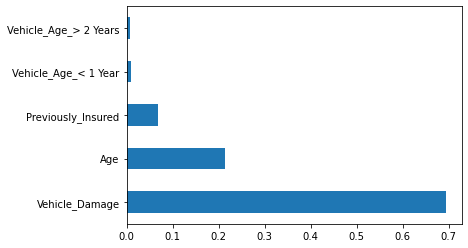

In [36]:
feat_importances = pd.Series(dt_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

It seems Linear Model doesn't do well for our model, especially compared to the Tree Model. 60% Precision on Decision Tree could become our new benchmark for the next model we would develop. Evaluate the feature importances, it seems Vehicle Damage feature contribute the most into the splitting. 

Let's explore more with ensemble tree model.

In [37]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [38]:
# Random Forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

{'accuracy': 0.8774894387447194,
 'recall': 0.001819738813958467,
 'precision': 0.5666666666666667,
 'f1_score': 0.0036278275714895433}

In [39]:
# Gradient Boosting
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
print_binary_evaluation(y_test, y_pred)

C:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8774369604576107,
 'recall': 0.0,
 'precision': 0.0,
 'f1_score': 0.0}